In [2]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')



C:\Users\black\AppData\Local\Temp\ipykernel_6312\1164176946.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('./dl-course-data/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [4]:
hotel.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


# 1) Define Model #
​
The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.
​
Define a model with an architecture given by this diagram:
​
<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/V04o59Z.png" width="400" alt="Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense.">
<figcaption style="textalign: center; font-style: italic"><center>Diagram of a binary classifier.</center></figcaption>
</figure>
​

In [5]:
input_shape

[63]

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


# 2) Add Optimizer, Loss, and Metric #

Now compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [7]:
# YOUR CODE HERE
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['binary_accuracy']

)

Finally, run this cell to train the model and view the learning curves. It may run for around 60 to 70 epochs, which could take a minute or two.

Epoch 1/200
175/175 [==============================] - 14s 44ms/step - loss: 0.4805 - binary_accuracy: 0.7728 - val_loss: 0.4286 - val_binary_accuracy: 0.7963
Epoch 2/200
175/175 [==============================] - 6s 35ms/step - loss: 0.4231 - binary_accuracy: 0.8016 - val_loss: 0.4020 - val_binary_accuracy: 0.8145
Epoch 3/200
175/175 [==============================] - 7s 40ms/step - loss: 0.4085 - binary_accuracy: 0.8100 - val_loss: 0.3924 - val_binary_accuracy: 0.8178
Epoch 4/200
175/175 [==============================] - 6s 34ms/step - loss: 0.4020 - binary_accuracy: 0.8123 - val_loss: 0.3898 - val_binary_accuracy: 0.8180
Epoch 5/200
175/175 [==============================] - 7s 38ms/step - loss: 0.3969 - binary_accuracy: 0.8155 - val_loss: 0.3869 - val_binary_accuracy: 0.8210
Epoch 6/200
175/175 [==============================] - 6s 35ms/step - loss: 0.3937 - binary_accuracy: 0.8167 - val_loss: 0.3820 - val_binary_accuracy: 0.8215
Epoch 7/200
175/175 [==============================

<Axes: title={'center': 'Accuracy'}>

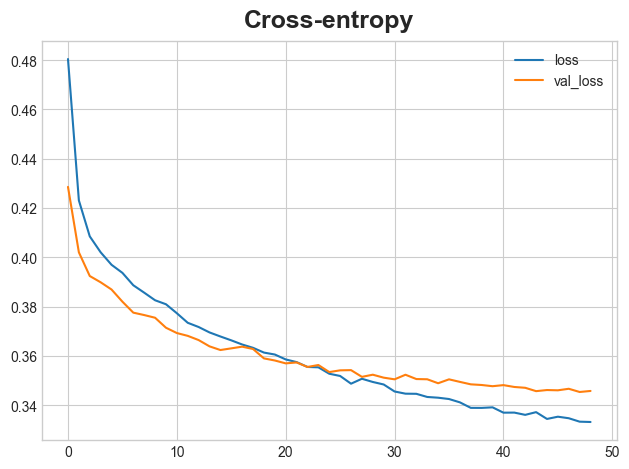

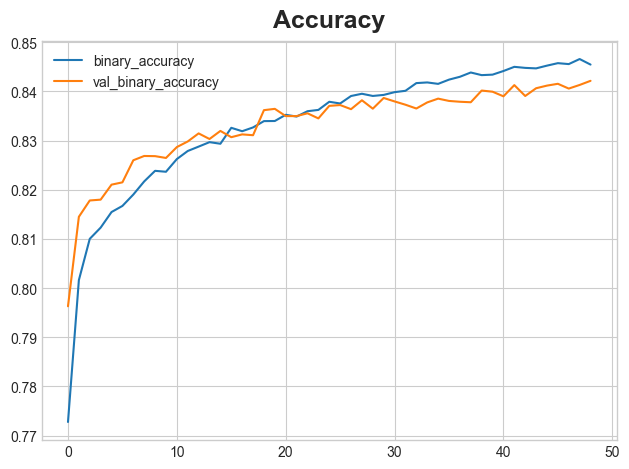

In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

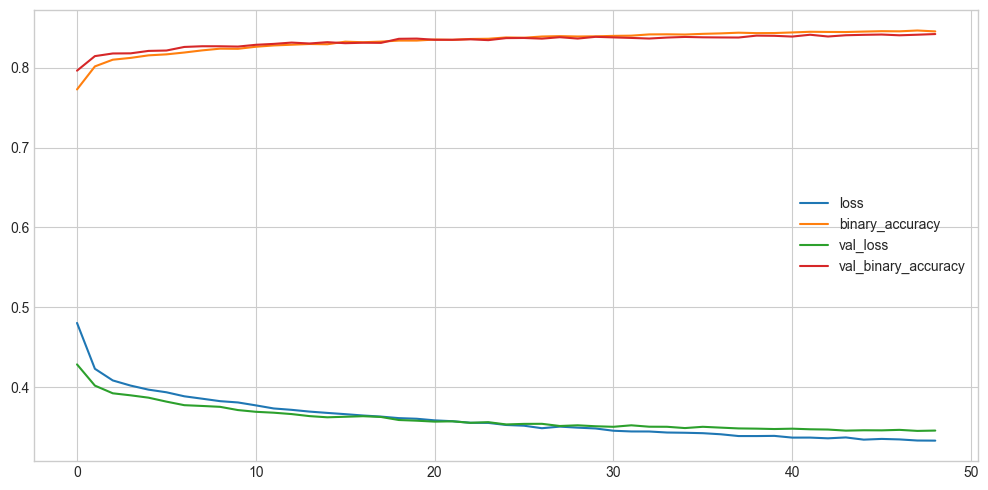

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
# learning_data.head()
history_df.plot(figsize=(10,5))
plt.grid(True)
plt.show()

# 3) Train and Evaluate #


What do you think about the learning curves? Does it look like the model underfit or overfit? Was the cross-entropy loss a good stand-in for accuracy?

Though we can see the training loss continuing to fall, the early stopping callback prevented any overfitting. Moreover, the accuracy rose at the same rate as the cross-entropy fell, so it appears that minimizing cross-entropy was a good stand-in. All in all, it looks like this training was a success!


In [10]:
model.evaluate(X_valid, y_valid)

933/933 [==============================] - 3s 3ms/step - loss: 0.3457 - binary_accuracy: 0.8406


[0.34565499424934387, 0.8406258225440979]

In [11]:
import numpy as np
y_pred = np.round(model.predict(X_valid))


933/933 [==============================] - 3s 3ms/step


In [13]:
print(y_pred.shape)
print(y_valid.shape)
y_test = np.array(y_valid).reshape(-1,1)
print(y_test.shape)

(29848, 1)
(29848,)
(29848, 1)


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test,y_pred)


array([[17166,  1626],
       [ 3131,  7925]], dtype=int64)

In [15]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     18792
           1       0.83      0.72      0.77     11056

    accuracy                           0.84     29848
   macro avg       0.84      0.82      0.82     29848
weighted avg       0.84      0.84      0.84     29848

